In [1]:
import os
import re
import pandas as pd
import numpy as np
import yaml
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set style for better-looking plots
plt.style.use('default')
sns.set_palette("husl")

In [2]:
DATA_DIRS = {
    "train": "./data/train/train_splits",
    "val": "./data/dev/dev_splits_complete",
    "test": "./data/test/output_repeated_splits_test"
}

OUTPUT_BASE = "./output"

os.makedirs(OUTPUT_BASE, exist_ok=True)

## Carregamento e Transformação

In [3]:
def to_seconds(t):
    h, m, s_ms = t.split(":")
    s, ms = s_ms.split(",")
    return int(h)*3600 + int(m)*60 + int(s) + int(ms)/1000

def to_snake_case(name: str) -> str:
    """Convert a string (like a column name) to snake_case."""
    name = name.strip()
    name = re.sub(r"[^\w\s]", "", name)
    name = re.sub(r"\s+", "_", name)
    return name.lower()

def prepare_df(df: pd.DataFrame):
    df["start_s"] = df["StartTime"].apply(to_seconds)
    df["end_s"] = df["EndTime"].apply(to_seconds)
    df["duration_s"] = df["end_s"] - df["start_s"]

    invalid = df[df["duration_s"] <= 0]
    if len(invalid) > 0:
        print(f"Warning: Found {len(invalid)} rows with invalid duration, removing them.")
        df = df[df["duration_s"] > 0]

    df = df.drop(columns=["Sr No.", "StartTime", "EndTime", "Season", "Episode", "Sentiment"])

    df.columns = [to_snake_case(c) for c in df.columns]

    return df

In [4]:
train_df = prepare_df(pd.read_csv("./data/train_sent_emo.csv"))
test_df = prepare_df(pd.read_csv("./data/test_sent_emo.csv"))
val_df = prepare_df(pd.read_csv("./data/dev_sent_emo.csv"))

## Funções base

In [5]:
def load_config(path):
    with open(path, "r") as f:
        return yaml.safe_load(f)

def plot_confusion_matrix(y_true, y_pred, emotion_names, dataset_name="Dataset", model_name=""):
    """Plot confusion matrix for classification results."""
    cm = confusion_matrix(y_true, y_pred)
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_names, 
                yticklabels=emotion_names, ax=ax1, cbar_kws={'label': 'Count'})
    ax1.set_title(f'{model_name} - {dataset_name}: Matrix de Confusão (Quantidade)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Predicted', fontsize=10)
    ax1.set_ylabel('Actual', fontsize=10)
    ax1.tick_params(axis='x', rotation=45)
    ax1.tick_params(axis='y', rotation=0)
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=emotion_names,
                yticklabels=emotion_names, ax=ax2, cbar_kws={'label': 'Proportion'})
    ax2.set_title(f'{model_name} - {dataset_name}: Matrix de Confusão (Normalizada)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Predicted', fontsize=10)
    ax2.set_ylabel('Actual', fontsize=10)
    ax2.tick_params(axis='x', rotation=45)
    ax2.tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    return cm

def evaluate_model(y_true, y_pred, emotion_names, dataset_name="Dataset", model_name="", show_confusion_matrix=True):
    """Comprehensive evaluation function for classification models."""
    print(f"\n{'='*60}")
    print(f"{dataset_name} Evaluation Results")
    print(f"{'='*60}")
    
    acc = accuracy_score(y_true, y_pred)
    print(f"\nOverall Accuracy: {acc:.4f} ({acc*100:.2f}%)")
    
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=emotion_names, zero_division=0))
    
    if show_confusion_matrix:
        plot_confusion_matrix(y_true, y_pred, emotion_names, dataset_name, model_name)
    
    return acc

def load_embeddings(df: pd.DataFrame, cfg: dict, normalize: bool = False):
    """Return concatenated embeddings (X) and numeric emotion labels (y).
    - Tries to load all enabled modalities
    - Automatically pads/truncates inconsistent shapes
    - Replaces missing/corrupt embeddings with zeros
    - Optionally normalizes features
    """
    X_list = []

    def safe_load(path: Path):
        try:
            return np.load(path)
        except Exception:
            return None

    for mod in ["text", "audio", "video"]:
        if not cfg["modalities"].get(mod, {}).get("enabled", False):
            continue

        emb_path = Path(cfg["modalities"][mod]["path"])
        feats = []

        for _, r in df.iterrows():
            arr = safe_load(emb_path / f"{r.dialogue_id}_{r.utterance_id}.npy")
            feats.append(arr)

        valid = [a for a in feats if a is not None]
        if not valid:
            raise ValueError(f"No valid embeddings found for {mod}")

        lengths = [np.prod(a.shape) for a in valid]
        ref_len = int(np.median(lengths))

        def fix_shape(a):
            if a is None:
                return np.zeros(ref_len)
            flat = a.flatten()
            if flat.size == ref_len:
                return flat
            elif flat.size < ref_len:
                return np.pad(flat, (0, ref_len - flat.size))
            else:
                return flat[:ref_len]

        feats_fixed = [fix_shape(a) for a in feats]
        X_list.append(np.stack(feats_fixed))

    if not X_list:
        raise ValueError("No modalities enabled or loaded!")

    X = np.concatenate(X_list, axis=1)
    y = df["emotion"].astype("category").cat.codes.to_numpy()

    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    
    if normalize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    return X, y

## Logistic Regression


Training Logistic Regression...

Test Split Evaluation Results

Overall Accuracy: 0.5125 (51.25%)

Classification Report:
              precision    recall  f1-score   support

       anger       0.45      0.41      0.43       226
     disgust       0.16      0.45      0.24        55
        fear       0.07      0.27      0.11        44
         joy       0.57      0.51      0.54       332
     neutral       0.82      0.56      0.67       985
     sadness       0.19      0.30      0.23       129
    surprise       0.44      0.58      0.50       227

    accuracy                           0.51      1998
   macro avg       0.39      0.44      0.39      1998
weighted avg       0.62      0.51      0.55      1998



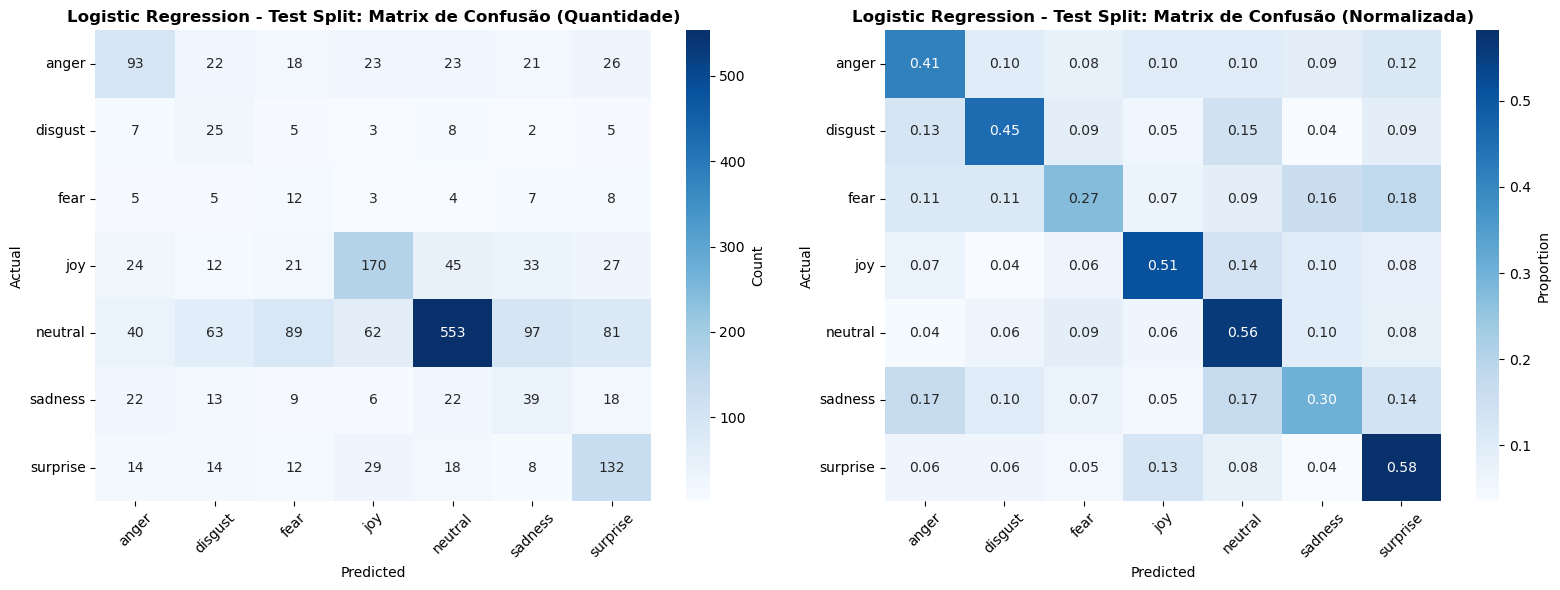


Validation Set Evaluation Results

Overall Accuracy: 0.1389 (13.89%)

Classification Report:
              precision    recall  f1-score   support

       anger       0.10      0.04      0.06       153
     disgust       0.02      0.05      0.03        22
        fear       0.03      0.42      0.06        40
         joy       0.14      0.09      0.11       163
     neutral       0.47      0.21      0.29       470
     sadness       0.08      0.05      0.07       111
    surprise       0.10      0.07      0.08       150

    accuracy                           0.14      1109
   macro avg       0.14      0.13      0.10      1109
weighted avg       0.26      0.14      0.17      1109



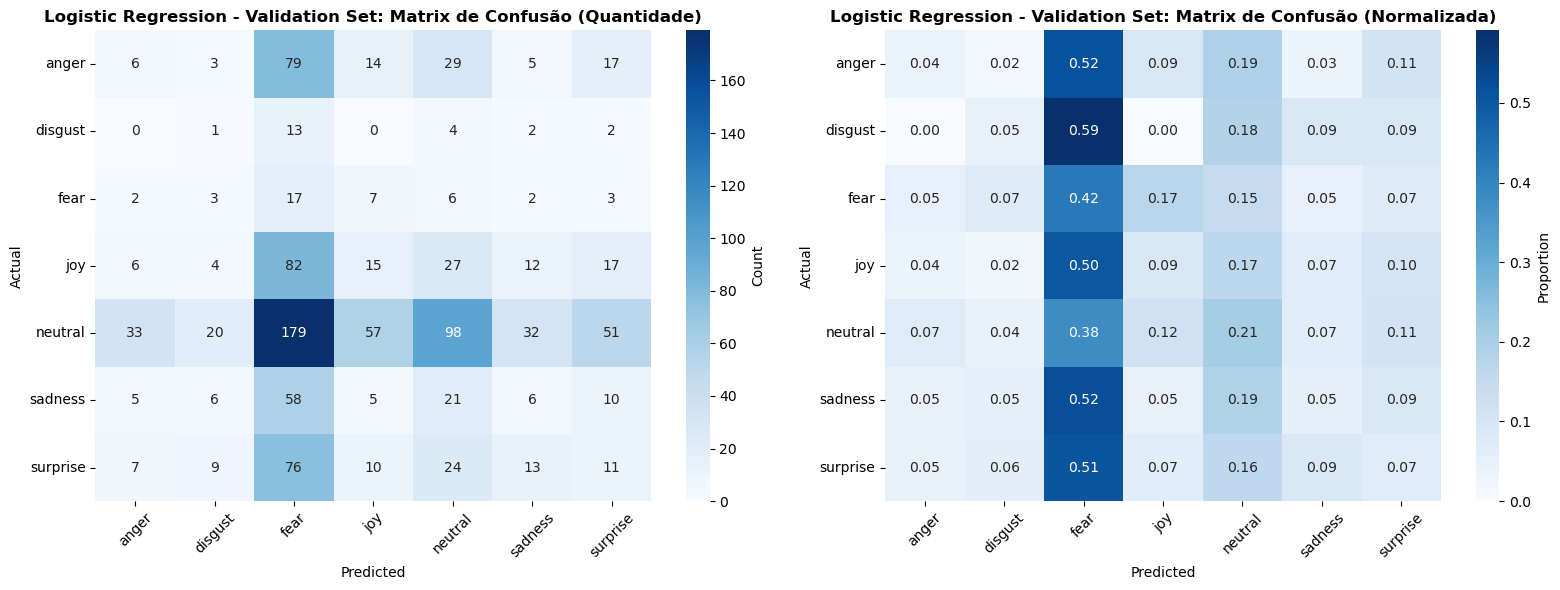


Summary: Test Accuracy = 0.5125, Validation Accuracy = 0.1389


In [6]:
cfg = load_config("configs/training/logistic.yaml")

X, y = load_embeddings(train_df, cfg, normalize=cfg["training"].get("normalize", False))
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=cfg["training"].get("test_split", 0.2), 
                                      random_state=cfg["training"]["seed"])

print("Training Logistic Regression...")
clf = LogisticRegression(max_iter=1000, class_weight="balanced")
clf.fit(Xtr, ytr)

pred_test = clf.predict(Xte)
emotion_names = train_df["emotion"].astype("category").cat.categories
test_acc = evaluate_model(yte, pred_test, emotion_names, "Test Split", model_name="Logistic Regression")

X_val, y_val = load_embeddings(val_df, cfg, normalize=cfg["training"].get("normalize", False))
pred_val = clf.predict(X_val)
val_acc = evaluate_model(y_val, pred_val, val_df["emotion"].astype("category").cat.categories, "Validation Set", model_name="Logistic Regression")

print(f"\n{'='*60}")
print(f"Summary: Test Accuracy = {test_acc:.4f}, Validation Accuracy = {val_acc:.4f}")
print(f"{'='*60}")

## SVM (Support Vector Machine)


Training SVM...

Test Split Evaluation Results

Overall Accuracy: 0.5801 (58.01%)

Classification Report:
              precision    recall  f1-score   support

       anger       0.45      0.44      0.44       226
     disgust       0.23      0.13      0.16        55
        fear       0.20      0.23      0.22        44
         joy       0.55      0.48      0.51       332
     neutral       0.76      0.72      0.74       985
     sadness       0.23      0.28      0.25       129
    surprise       0.44      0.61      0.51       227

    accuracy                           0.58      1998
   macro avg       0.41      0.41      0.40      1998
weighted avg       0.59      0.58      0.58      1998



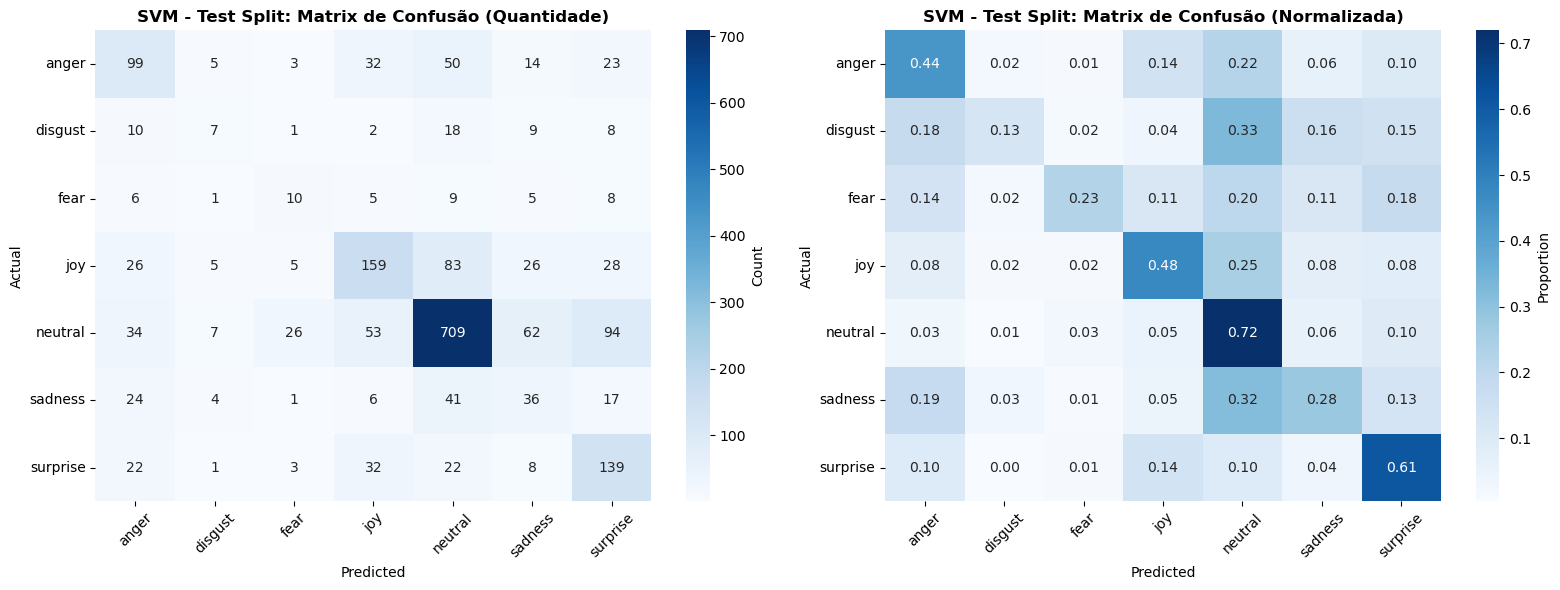


Validation Set Evaluation Results

Overall Accuracy: 0.2876 (28.76%)

Classification Report:
              precision    recall  f1-score   support

       anger       0.08      0.03      0.05       153
     disgust       0.00      0.00      0.00        22
        fear       0.03      0.03      0.03        40
         joy       0.10      0.06      0.07       163
     neutral       0.40      0.61      0.48       470
     sadness       0.07      0.04      0.05       111
    surprise       0.10      0.09      0.10       150

    accuracy                           0.29      1109
   macro avg       0.11      0.12      0.11      1109
weighted avg       0.22      0.29      0.24      1109



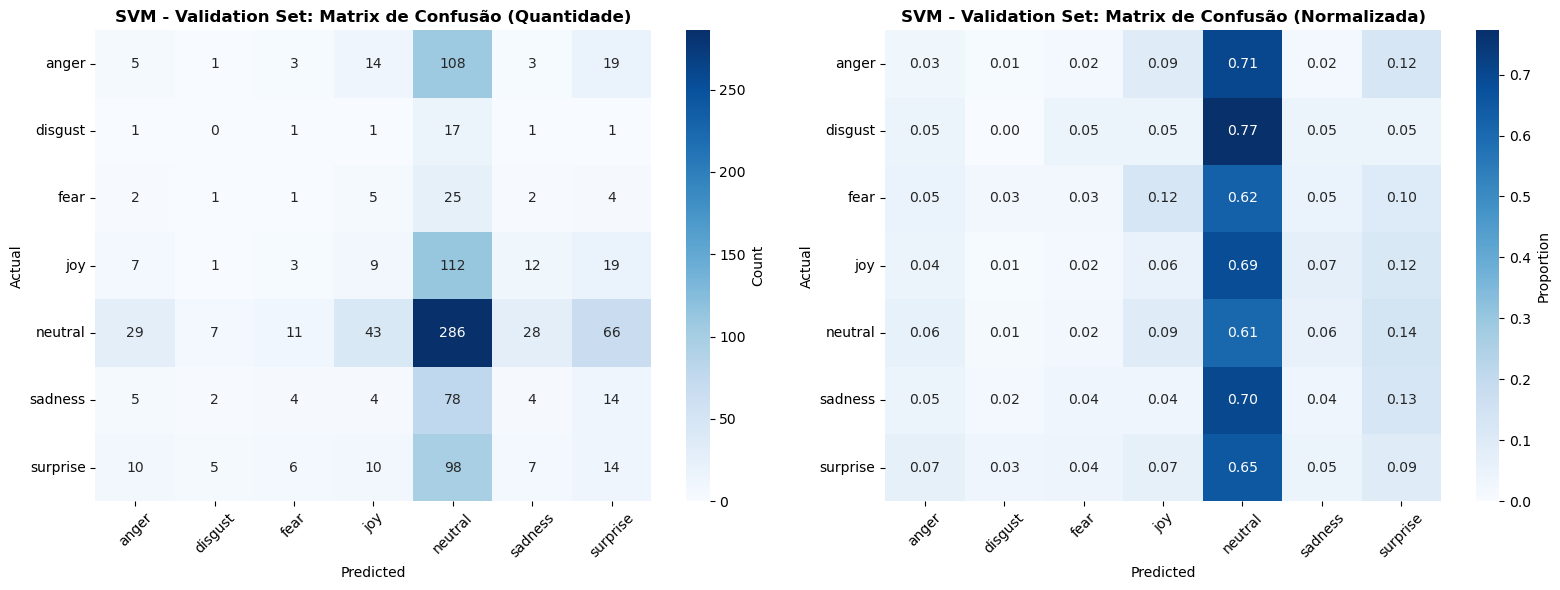


Summary: Test Accuracy = 0.5801, Validation Accuracy = 0.2876


In [7]:
from sklearn.svm import SVC

cfg = load_config("configs/training/svm.yaml")

X, y = load_embeddings(train_df, cfg, normalize=cfg["training"].get("normalize", False))
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=cfg["training"]["test_split"], 
                                      random_state=cfg["training"]["seed"])

clf = SVC(
    kernel=cfg["model"]["kernel"],
    C=cfg["model"]["C"],
    gamma=cfg["model"]["gamma"],
    class_weight=cfg["model"]["class_weight"],
    random_state=cfg["training"]["seed"]
)

print("Training SVM...")
clf.fit(Xtr, ytr)

pred_test = clf.predict(Xte)
emotion_names = train_df["emotion"].astype("category").cat.categories
test_acc = evaluate_model(yte, pred_test, emotion_names, "Test Split", model_name="SVM")

X_val, y_val = load_embeddings(val_df, cfg, normalize=cfg["training"].get("normalize", False))
pred_val = clf.predict(X_val)
val_acc = evaluate_model(y_val, pred_val, val_df["emotion"].astype("category").cat.categories, "Validation Set", model_name="SVM")

print(f"\n{'='*60}")
print(f"Summary: Test Accuracy = {test_acc:.4f}, Validation Accuracy = {val_acc:.4f}")
print(f"{'='*60}")


## Random Forest


Training Random Forest...

Test Split Evaluation Results

Overall Accuracy: 0.6026 (60.26%)

Classification Report:
              precision    recall  f1-score   support

       anger       0.48      0.26      0.34       226
     disgust       0.00      0.00      0.00        55
        fear       0.00      0.00      0.00        44
         joy       0.49      0.36      0.41       332
     neutral       0.63      0.95      0.75       985
     sadness       1.00      0.02      0.03       129
    surprise       0.64      0.40      0.49       227

    accuracy                           0.60      1998
   macro avg       0.46      0.28      0.29      1998
weighted avg       0.58      0.60      0.54      1998



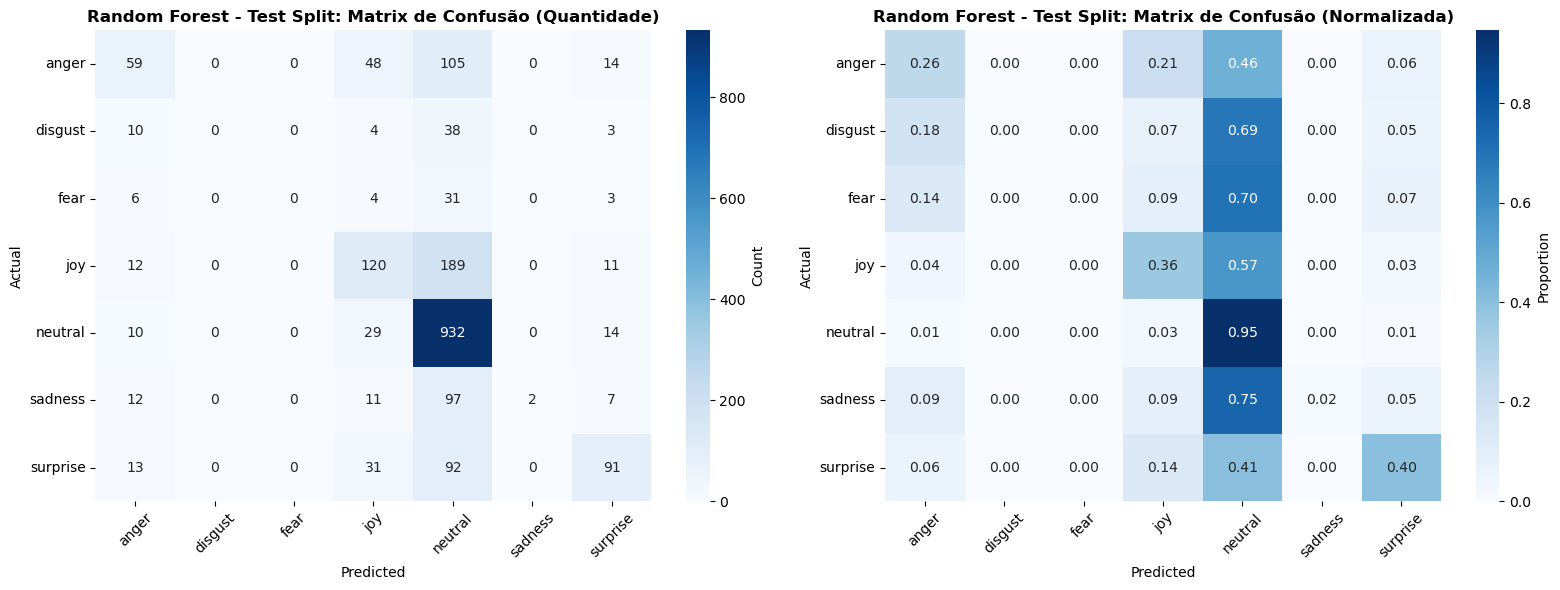


Validation Set Evaluation Results

Overall Accuracy: 0.3255 (32.55%)

Classification Report:
              precision    recall  f1-score   support

       anger       0.11      0.05      0.06       153
     disgust       0.00      0.00      0.00        22
        fear       0.05      0.03      0.03        40
         joy       0.12      0.08      0.10       163
     neutral       0.41      0.70      0.52       470
     sadness       0.10      0.03      0.04       111
    surprise       0.12      0.06      0.08       150

    accuracy                           0.33      1109
   macro avg       0.13      0.13      0.12      1109
weighted avg       0.24      0.33      0.26      1109



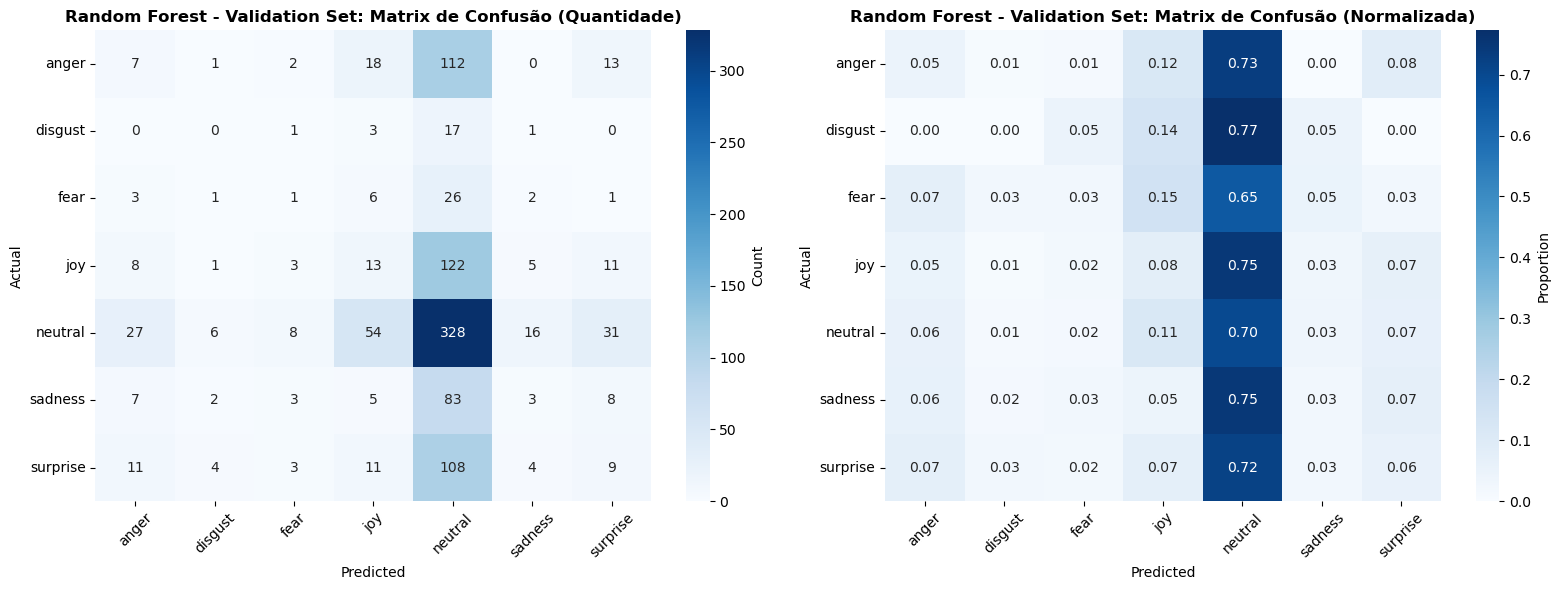


Summary: Test Accuracy = 0.6026, Validation Accuracy = 0.3255


In [8]:
from sklearn.ensemble import RandomForestClassifier

cfg = load_config("configs/training/random_forest.yaml")

X, y = load_embeddings(train_df, cfg, normalize=cfg["training"].get("normalize", False))
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=cfg["training"]["test_split"], 
                                      random_state=cfg["training"]["seed"])

clf = RandomForestClassifier(
    n_estimators=cfg["model"]["n_estimators"],
    max_depth=cfg["model"]["max_depth"],
    min_samples_split=cfg["model"]["min_samples_split"],
    min_samples_leaf=cfg["model"]["min_samples_leaf"],
    class_weight=cfg["model"]["class_weight"],
    max_features=cfg["model"]["max_features"],
    random_state=cfg["training"]["seed"],
    n_jobs=-1
)

print("Training Random Forest...")
clf.fit(Xtr, ytr)

pred_test = clf.predict(Xte)
emotion_names = train_df["emotion"].astype("category").cat.categories
test_acc = evaluate_model(yte, pred_test, emotion_names, "Test Split", model_name="Random Forest")

X_val, y_val = load_embeddings(val_df, cfg, normalize=cfg["training"].get("normalize", False))
pred_val = clf.predict(X_val)
val_acc = evaluate_model(y_val, pred_val, val_df["emotion"].astype("category").cat.categories, "Validation Set", model_name="Random Forest")

print(f"\n{'='*60}")
print(f"Summary: Test Accuracy = {test_acc:.4f}, Validation Accuracy = {val_acc:.4f}")
print(f"{'='*60}")


## MLP

In [9]:
class MLPClassifier(nn.Module):
    def __init__(self, in_dim, hidden, out_dim, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, out_dim)
        )

    def forward(self, x):
        return self.net(x)

In [10]:
def train_mlp(X, y, cfg):
    torch.manual_seed(cfg["training"]["seed"])
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=cfg["training"]["test_split"],
                                          random_state=cfg["training"]["seed"])

    Xtr_t = torch.tensor(Xtr, dtype=torch.float32)
    ytr_t = torch.tensor(ytr, dtype=torch.long)
    Xte_t = torch.tensor(Xte, dtype=torch.float32)
    yte_t = torch.tensor(yte, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t),
                              batch_size=cfg["training"]["batch_size"],
                              shuffle=True)

    model = MLPClassifier(
        in_dim=X.shape[1],
        hidden=cfg["model"]["hidden_size"],
        out_dim=len(np.unique(y)),
        dropout=cfg["model"]["dropout"]
    )
    criterion = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=float(cfg["training"]["learning_rate"]))

    best_acc = 0.0
    patience_counter = 0
    patience = cfg["training"].get("patience", None)
    early_stopping = cfg["training"].get("early_stopping", False)

    for epoch in range(cfg["training"]["epochs"]):
        model.train()
        epoch_loss = 0.0
        for xb, yb in train_loader:
            optim.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optim.step()
            epoch_loss += loss.item()

        if (epoch + 1) % 5 == 0 or early_stopping:
            model.eval()
            with torch.no_grad():
                preds = model(Xte_t).argmax(dim=1)
                acc = (preds == yte_t).float().mean().item()
                print(f"Epoch {epoch+1}/{cfg['training']['epochs']} - val acc: {acc:.3f}, loss: {epoch_loss/len(train_loader):.4f}")
            
            if early_stopping:
                if acc > best_acc:
                    best_acc = acc
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break

    model.eval()
    return model

Training MLP...
Epoch 5/50 - val acc: 0.591, loss: 1.2179
Epoch 10/50 - val acc: 0.629, loss: 1.1428
Epoch 15/50 - val acc: 0.632, loss: 1.1064
Epoch 20/50 - val acc: 0.606, loss: 1.0687
Epoch 25/50 - val acc: 0.629, loss: 1.0452
Epoch 30/50 - val acc: 0.635, loss: 1.0075
Epoch 35/50 - val acc: 0.634, loss: 0.9800
Epoch 40/50 - val acc: 0.627, loss: 0.9405
Epoch 45/50 - val acc: 0.627, loss: 0.9100
Epoch 50/50 - val acc: 0.626, loss: 0.8806

Test Split Evaluation Results

Overall Accuracy: 0.6256 (62.56%)

Classification Report:
              precision    recall  f1-score   support

       anger       0.49      0.39      0.43       226
     disgust       0.30      0.05      0.09        55
        fear       0.40      0.05      0.08        44
         joy       0.56      0.46      0.50       332
     neutral       0.72      0.87      0.79       985
     sadness       0.28      0.16      0.20       129
    surprise       0.48      0.58      0.52       227

    accuracy                   

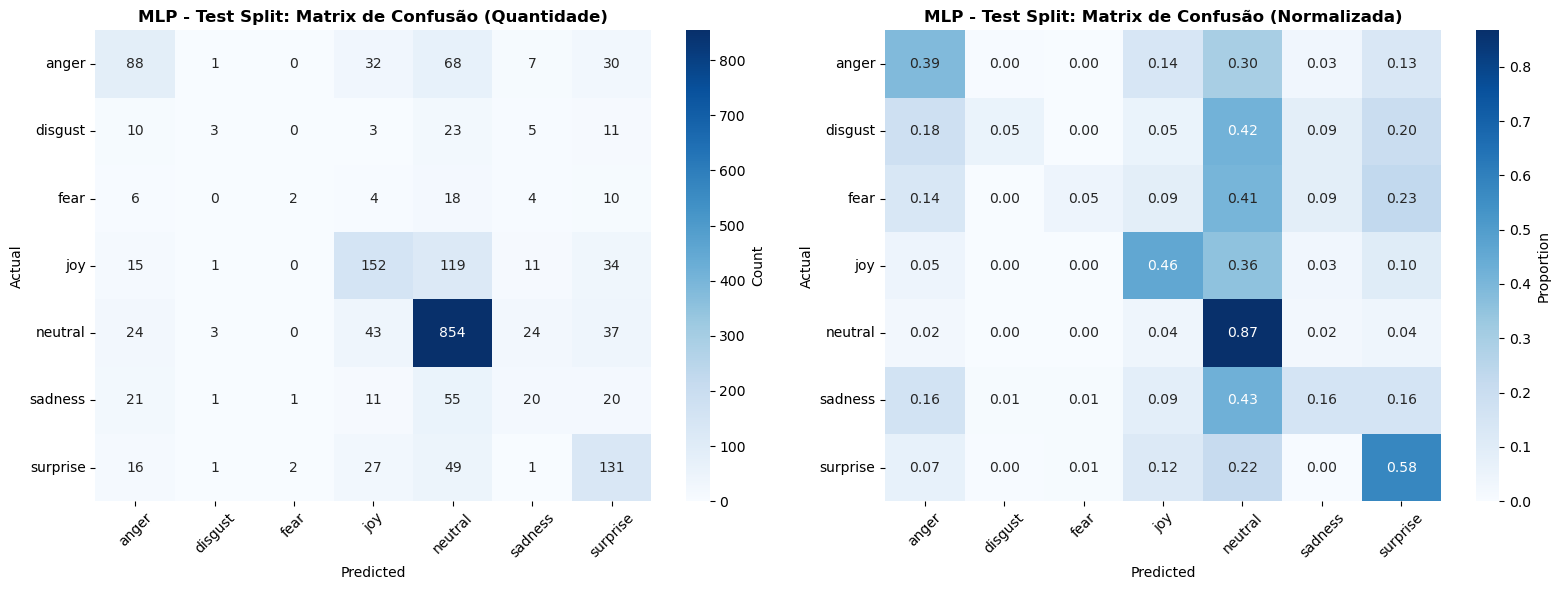


Validation Set Evaluation Results

Overall Accuracy: 0.3192 (31.92%)

Classification Report:
              precision    recall  f1-score   support

       anger       0.05      0.02      0.03       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.13      0.08      0.10       163
     neutral       0.40      0.69      0.51       470
     sadness       0.08      0.02      0.03       111
    surprise       0.11      0.07      0.09       150

    accuracy                           0.32      1109
   macro avg       0.11      0.13      0.11      1109
weighted avg       0.22      0.32      0.25      1109



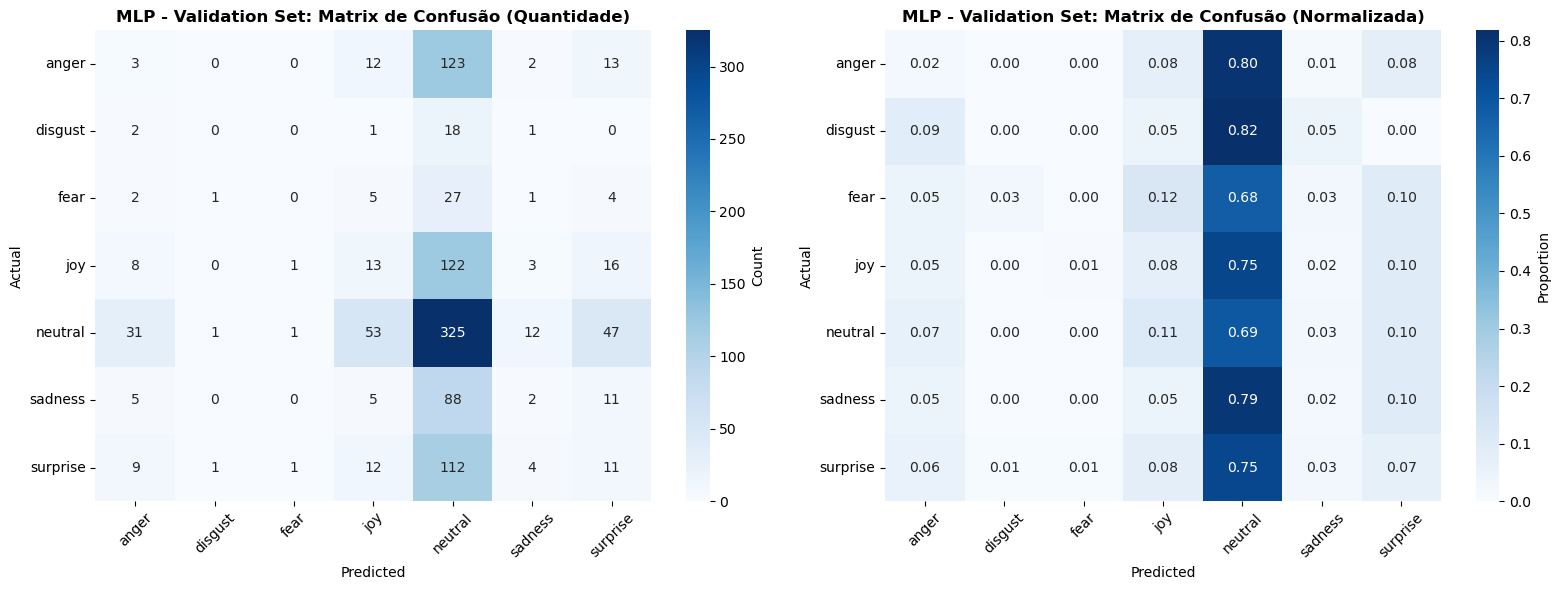


Summary: Test Accuracy = 0.6256, Validation Accuracy = 0.3192


In [11]:
cfg = load_config("./configs/training/mlp.yaml")
X, y = load_embeddings(train_df, cfg, normalize=cfg["training"].get("normalize", False))

print("Training MLP...")
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=cfg["training"]["test_split"],
                                      random_state=cfg["training"]["seed"])
clf = train_mlp(X, y, cfg)

Xte_t = torch.tensor(Xte, dtype=torch.float32)
with torch.no_grad():
    pred_test = clf(Xte_t).argmax(dim=1).numpy()
emotion_names = train_df["emotion"].astype("category").cat.categories
test_acc = evaluate_model(yte, pred_test, emotion_names, "Test Split", model_name="MLP")

X_val, y_val = load_embeddings(val_df, cfg, normalize=cfg["training"].get("normalize", False))
X_val_t = torch.tensor(X_val, dtype=torch.float32)
with torch.no_grad():
    pred_val = clf(X_val_t).argmax(dim=1).numpy()
val_acc = evaluate_model(y_val, pred_val, val_df["emotion"].astype("category").cat.categories, "Validation Set", model_name="MLP")

print(f"\n{'='*60}")
print(f"Summary: Test Accuracy = {test_acc:.4f}, Validation Accuracy = {val_acc:.4f}")
print(f"{'='*60}")

## Deep MLP (Multi-layer)


In [12]:
class DeepMLPClassifier(nn.Module):
    def __init__(self, in_dim, hidden_sizes, out_dim, dropout=0.3, batch_norm=False):
        super().__init__()
        layers = []
        prev_size = in_dim
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            if batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def train_deep_mlp(X, y, cfg):
    torch.manual_seed(cfg["training"]["seed"])
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=cfg["training"]["test_split"],
                                          random_state=cfg["training"]["seed"])

    Xtr_t = torch.tensor(Xtr, dtype=torch.float32)
    ytr_t = torch.tensor(ytr, dtype=torch.long)
    Xte_t = torch.tensor(Xte, dtype=torch.float32)
    yte_t = torch.tensor(yte, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t),
                              batch_size=cfg["training"]["batch_size"],
                              shuffle=True)

    model = DeepMLPClassifier(
        in_dim=X.shape[1],
        hidden_sizes=cfg["model"]["hidden_sizes"],
        out_dim=len(np.unique(y)),
        dropout=cfg["model"]["dropout"],
        batch_norm=cfg["model"].get("batch_norm", False)
    )
    criterion = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=float(cfg["training"]["learning_rate"]))

    best_acc = 0.0
    patience_counter = 0
    patience = cfg["training"].get("patience", None)
    early_stopping = cfg["training"].get("early_stopping", False)

    for epoch in range(cfg["training"]["epochs"]):
        model.train()
        epoch_loss = 0.0
        for xb, yb in train_loader:
            optim.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optim.step()
            epoch_loss += loss.item()

        if (epoch + 1) % 5 == 0 or early_stopping:
            model.eval()
            with torch.no_grad():
                preds = model(Xte_t).argmax(dim=1)
                acc = (preds == yte_t).float().mean().item()
                print(f"Epoch {epoch+1}/{cfg['training']['epochs']} - val acc: {acc:.3f}, loss: {epoch_loss/len(train_loader):.4f}")
            
            if early_stopping:
                if acc > best_acc:
                    best_acc = acc
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break

    model.eval()
    return model

Training Deep MLP...
Epoch 1/100 - val acc: 0.586, loss: 1.4446
Epoch 2/100 - val acc: 0.625, loss: 1.2676
Epoch 3/100 - val acc: 0.618, loss: 1.2112
Epoch 4/100 - val acc: 0.625, loss: 1.1661
Epoch 5/100 - val acc: 0.629, loss: 1.1282
Epoch 6/100 - val acc: 0.633, loss: 1.1092
Epoch 7/100 - val acc: 0.628, loss: 1.0764
Epoch 8/100 - val acc: 0.639, loss: 1.0557
Epoch 9/100 - val acc: 0.626, loss: 1.0415
Epoch 10/100 - val acc: 0.625, loss: 1.0072
Epoch 11/100 - val acc: 0.632, loss: 0.9857
Epoch 12/100 - val acc: 0.624, loss: 0.9613
Epoch 13/100 - val acc: 0.620, loss: 0.9334
Epoch 14/100 - val acc: 0.615, loss: 0.9136
Epoch 15/100 - val acc: 0.612, loss: 0.8787
Epoch 16/100 - val acc: 0.601, loss: 0.8591
Epoch 17/100 - val acc: 0.606, loss: 0.8302
Epoch 18/100 - val acc: 0.607, loss: 0.8031
Early stopping at epoch 18

Test Split Evaluation Results

Overall Accuracy: 0.6071 (60.71%)

Classification Report:
              precision    recall  f1-score   support

       anger       0.41 

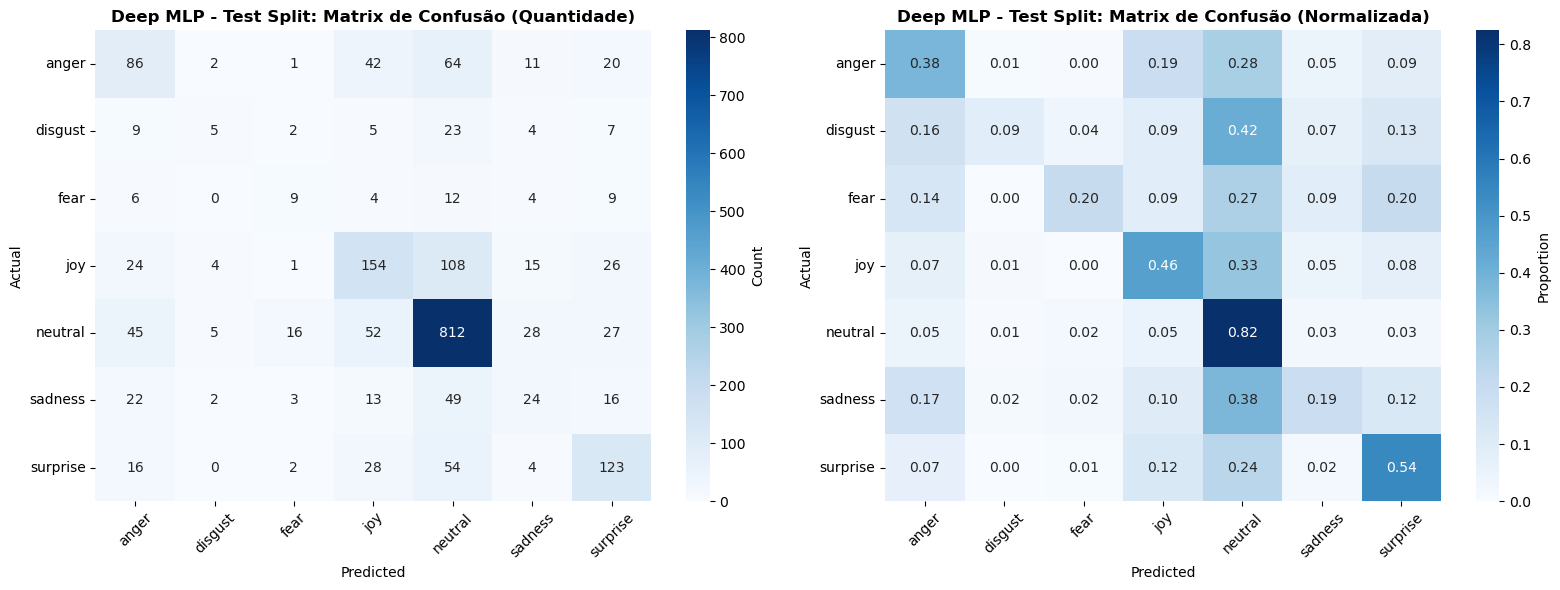


Validation Set Evaluation Results

Overall Accuracy: 0.2290 (22.90%)

Classification Report:
              precision    recall  f1-score   support

       anger       0.09      0.03      0.04       153
     disgust       0.00      0.00      0.00        22
        fear       0.03      0.03      0.03        40
         joy       0.15      0.45      0.22       163
     neutral       0.45      0.33      0.38       470
     sadness       0.08      0.03      0.04       111
    surprise       0.11      0.11      0.11       150

    accuracy                           0.23      1109
   macro avg       0.13      0.14      0.12      1109
weighted avg       0.25      0.23      0.22      1109



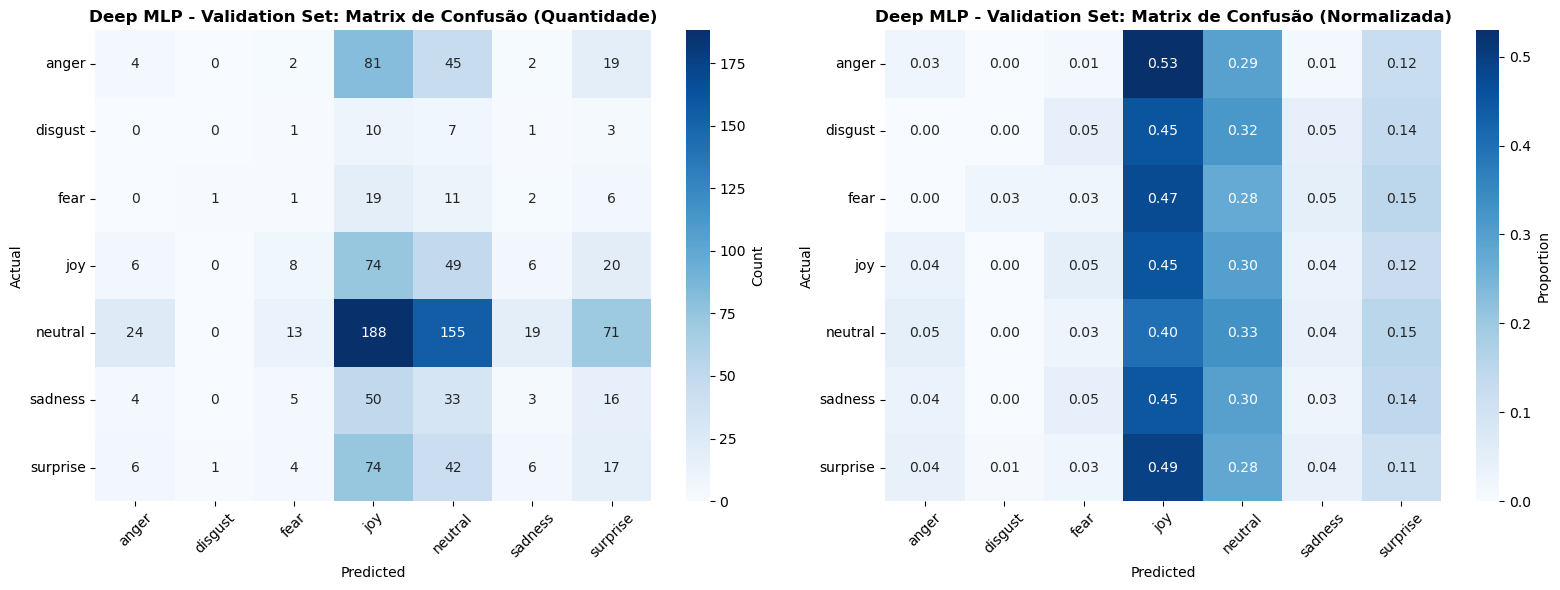


Summary: Test Accuracy = 0.6071, Validation Accuracy = 0.2290


In [13]:
cfg = load_config("configs/training/deep_mlp.yaml")
X, y = load_embeddings(train_df, cfg, normalize=cfg["training"].get("normalize", False))

print("Training Deep MLP...")
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=cfg["training"]["test_split"],
                                      random_state=cfg["training"]["seed"])
deep_mlp = train_deep_mlp(X, y, cfg)

Xte_t = torch.tensor(Xte, dtype=torch.float32)
with torch.no_grad():
    pred_test = deep_mlp(Xte_t).argmax(dim=1).numpy()
emotion_names = train_df["emotion"].astype("category").cat.categories
test_acc = evaluate_model(yte, pred_test, emotion_names, "Test Split", model_name="Deep MLP")

X_val, y_val = load_embeddings(val_df, cfg, normalize=cfg["training"].get("normalize", False))
X_val_t = torch.tensor(X_val, dtype=torch.float32)
with torch.no_grad():
    pred_val = deep_mlp(X_val_t).argmax(dim=1).numpy()
val_acc = evaluate_model(y_val, pred_val, val_df["emotion"].astype("category").cat.categories, "Validation Set", model_name="Deep MLP")

print(f"\n{'='*60}")
print(f"Summary: Test Accuracy = {test_acc:.4f}, Validation Accuracy = {val_acc:.4f}")
print(f"{'='*60}")
